In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from typing import *
import numpy.typing as npt
import cv2
import matplotlib.pyplot as plt
import torch
import os
from myImgLib import *

In [3]:
dataDir = "./DATA"

In [41]:
img1CV = cv2.imread(os.path.join(dataDir, "apple.PNG"))
img1 = cv2.cvtColor(img1CV, cv2.COLOR_BGR2RGB)

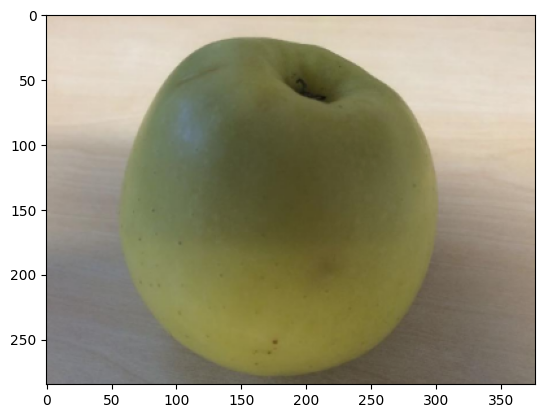

In [42]:
plt.imshow(img1)

In [43]:

def maxPool(channel: npt.NDArray, size = 2):
    # TODO
    h, w = channel.shape
    output = np.zeros((h // 2, w // 2), dtype=np.int16)
    for y in range(0, h//2):
        for x in range(0, w//2):
            # print(y, x)
            output[y, x] = np.max(channel[y*size: y*size + size, x*size: x*size + size])
    return output

def unPool(channel: npt.NDArray, size = 2):
    # TODO
    h, w = channel.shape
    output = np.zeros((h * 2, w * 2), dtype=np.int16)
    for y in range(0, h):
        for x in range(0, w):
            # print(y, x)
            output[y*2-1: y*2+1, x*2-1: x*2 + 1] = channel[y, x]
    return output
    
    

def downBy2(img: npt.NDArray):
    assert img.shape[-1] == 3
    h, w, c = img.shape
    # we will max pool
    outputChannels = []
    for k in range(c):
        channel = img[:, :, k]
        outputChannels.append(maxPool(channel))

    return np.stack(outputChannels, axis=-1)


def upBy2(img: npt.NDArray):
    assert img.shape[-1] == 3
    h, w, c = img.shape
    # we will max pool
    outputChannels = []
    for k in range(c):
        channel = img[:, :, k]
        outputChannels.append(unPool(channel))

    return np.stack(outputChannels, axis=-1)
        
def getOctaveLevels(img: npt.NDArray):
    size = min(img.shape[0], img.shape[1])
    # min size is 8x8. 
    # each level reduces dim by 2^l
    return int(np.log2(size) - 3)

def getPyramid(img: npt.NDArray) -> List[npt.NDArray]:
    smoothKernel = np.array([
        [0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111],
        [0.1111, 0.1111, 0.1111],
    ])

    nLayer = getOctaveLevels(img)
    downSamples = [img]
    for _ in range(nLayer):
        # 1. smooth
        smooth = apply2DConvolution(img, smoothKernel)
        # 2. downsample
        newImg = downBy2(smooth)
        downSamples.append(newImg)
        img = newImg
    return downSamples

def getLaplacianPyramid(gaussianPyramid: List[npt.NDArray]) -> List[npt.NDArray]:
    diffs = []
    for k in range(len(gaussianPyramid) - 1):
        upSampledNext = upBy2(gaussianPyramid[k+1])
        current = gaussianPyramid[k]
        blank = np.zeros_like(current)
        blank[:upSampledNext.shape[0], :upSampledNext.shape[1]] = upSampledNext
        h_k = current - blank
        # h_k = np.clip(h_k, 0, 255)
        diffs.append(h_k)

    diffs.append(gaussianPyramid[-1].copy())
    return diffs

def reconstructFromLaplacianPyramid(lapPyramid: List[npt.NDArray], smallestDownsampled: npt.NDArray):
    # I_k = h_k + u(I_k+1)
    previous = smallestDownsampled
    for k in range(len(lapPyramid) - 2, -1, -1):
        previousUpped = upBy2(previous)
        h_k = lapPyramid[k]
        blank = np.zeros_like(h_k)
        blank[:previousUpped.shape[0], :previousUpped.shape[1]] = previousUpped
        previous = h_k + blank
    return previous
            

In [44]:
a = np.array([
    [1, 2, 3, 4],
    [4, 5, 6, 6],
    [7, 8, 9, 10],
    [7, 8, 9, 10]
])
maxPool(a)

array([[ 5,  6],
       [ 8, 10]], dtype=int16)

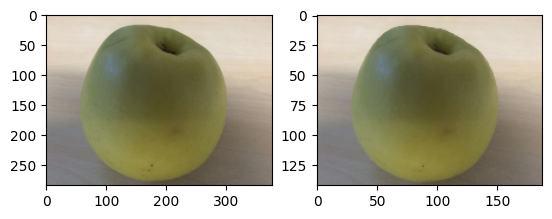

(285, 377, 3) (142, 188, 3)


In [45]:
output = downBy2(img1)
juxtapose(img1, output)

print(img1.shape, output.shape)

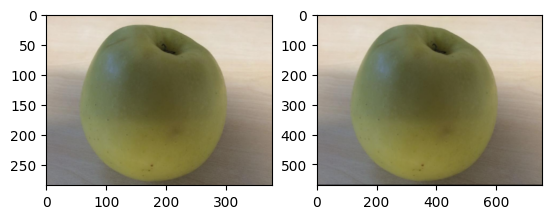

(285, 377, 3) (570, 754, 3)


In [46]:
output = upBy2(img1)
juxtapose(img1, output)
print(img1.shape, output.shape)

In [47]:
gaussianPyramid = getPyramid(img1)

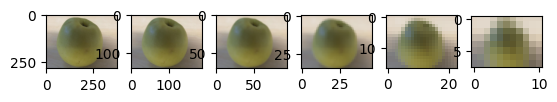

In [48]:
juxtaposeAll(gaussianPyramid)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


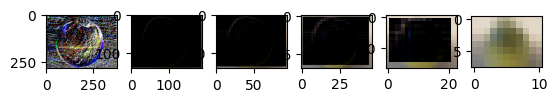

In [49]:
lapPyramid = getLaplacianPyramid(gaussianPyramid)
juxtaposeAll(lapPyramid)

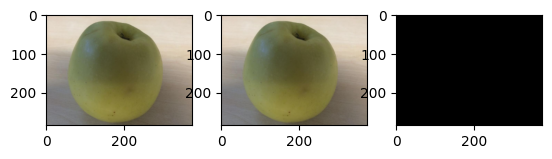

In [50]:
output = reconstructFromLaplacianPyramid(lapPyramid, gaussianPyramid[-1])
diff = np.clip(img1 - output, 0, 255)
juxtaposeAll([img1, output, diff])

In [51]:
np.sum(diff)

0

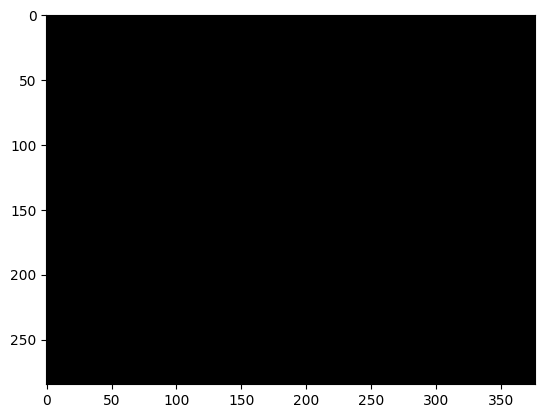

In [52]:
plt.imshow(diff)